### imports:

In [46]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn import svm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import random
import math
import matplotlib.collections
np.set_printoptions(threshold=np.inf)
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
# from wandb import magic

# The Data:

In [47]:
data_list = []
with open("winequality-white.csv") as csvfile:
    first_line = True
    reader = csv.reader(csvfile)
    for row in reader:
        if first_line:
            vars = row[0].replace('"','').split(";")
            first_line = False
            continue
        current_row = row[0].split(';')
        current_row = [float(num) for num in current_row]
        data_list.append(current_row)
data = pd.DataFrame(data_list)
data.columns = vars
data.head()        

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [3]:
X = data.drop(["quality"], axis=1)
Y = data["quality"]

# variables histograms before normalization:

##### The blue line is kernel density estimator.
##### The black line (norm) is maximum likelihood gaussian distribution fit.

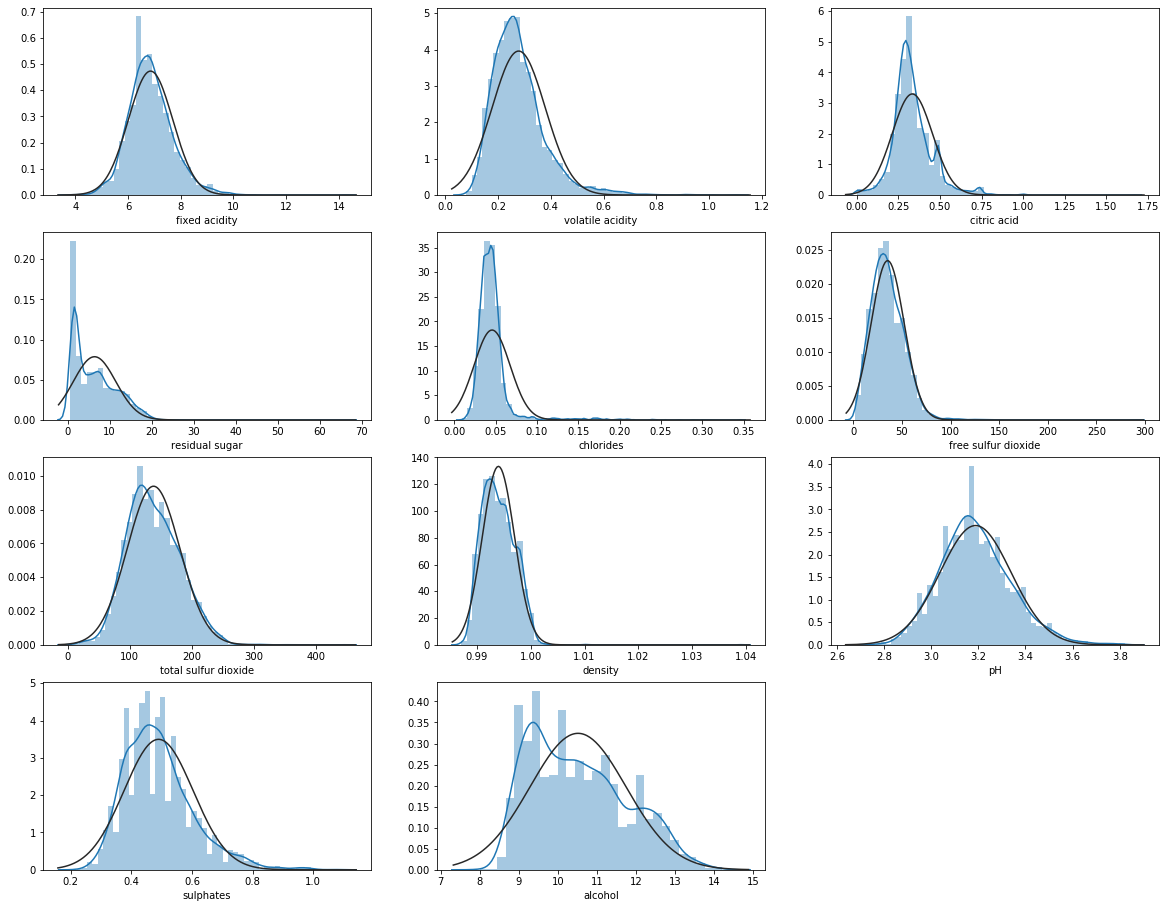

In [4]:
plt.figure(figsize = (20,20))

for i in range(1,12):
    plt.subplot(5,3,i)
    sns.distplot(X[X.columns[i-1]], fit=norm)
# fit=norm
# hist=False

## variables normalization using z-score:

In [5]:
normalized_X = (X - X.mean())/X.std()
normalized_X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.172079,-0.081762,0.213258,2.821061,-0.035351,0.569873,0.744489,2.331274,-1.246794,-0.349149,-1.393010
1,-0.657434,0.215874,0.047996,-0.944669,0.147732,-1.252891,-0.149669,-0.009153,0.739953,0.001342,-0.824192
2,1.475600,0.017450,0.543783,0.100272,0.193503,-0.312109,-0.973236,0.358628,0.475053,-0.436771,-0.336633
3,0.409083,-0.478608,-0.117266,0.415726,0.559670,0.687471,1.120977,0.525802,0.011479,-0.787262,-0.499152
4,0.409083,-0.478608,-0.117266,0.415726,0.559670,0.687471,1.120977,0.525802,0.011479,-0.787262,-0.499152


# variables histograms after normalization:

##### The blue line is kernel density estimator.
##### The black line (norm) is maximum likelihood gaussian distribution fit.

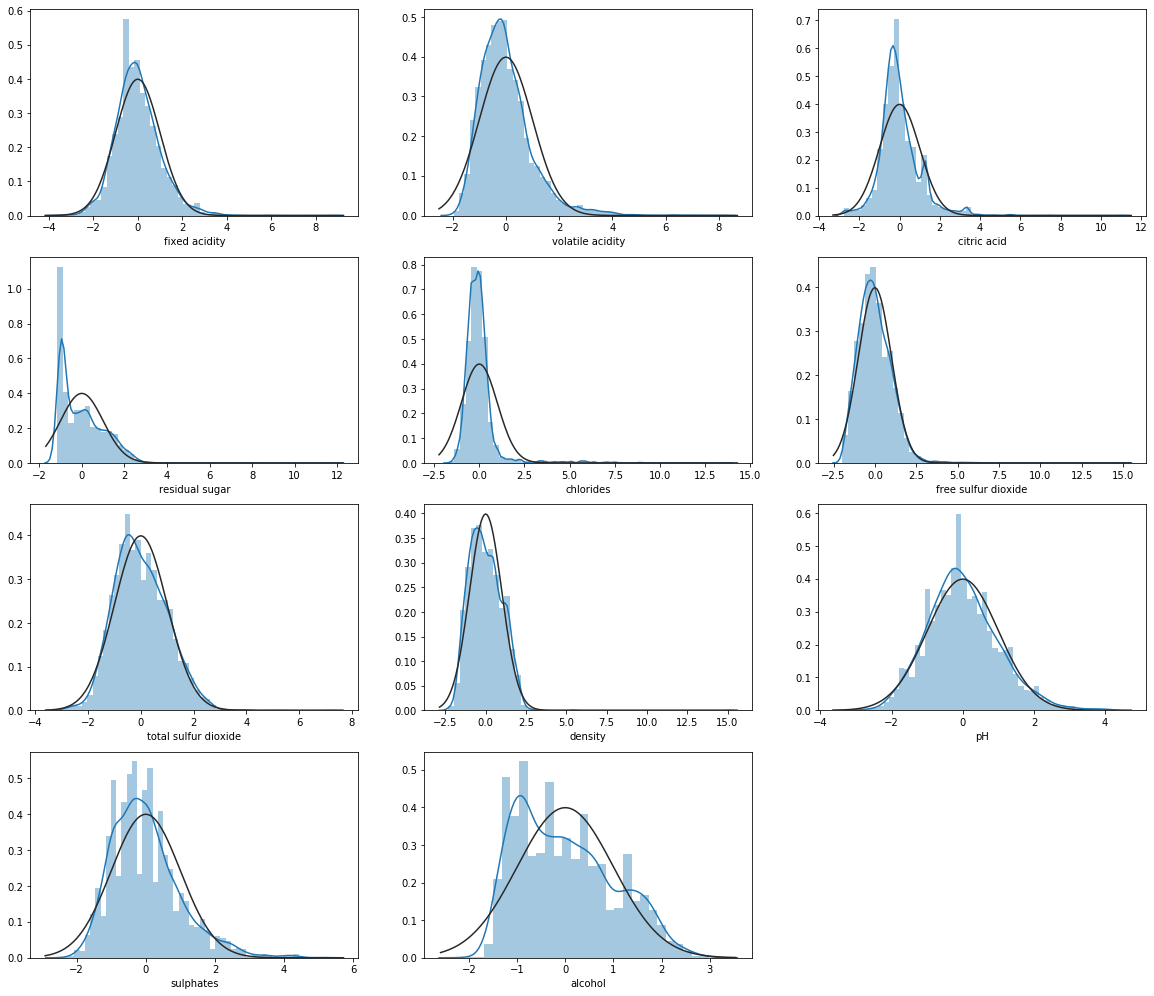

In [6]:
plt.figure(figsize = (20,22))

for i in range(1,12):
    plt.subplot(5,3,i)
    sns.distplot(normalized_X[normalized_X.columns[i-1]], fit=norm)
# fit=norm
# hist=False

# Cutting the data to training and test randomly:

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, Y, test_size=0.18, random_state=42)

# Heat map of the dependence of each feature on the othe ones.

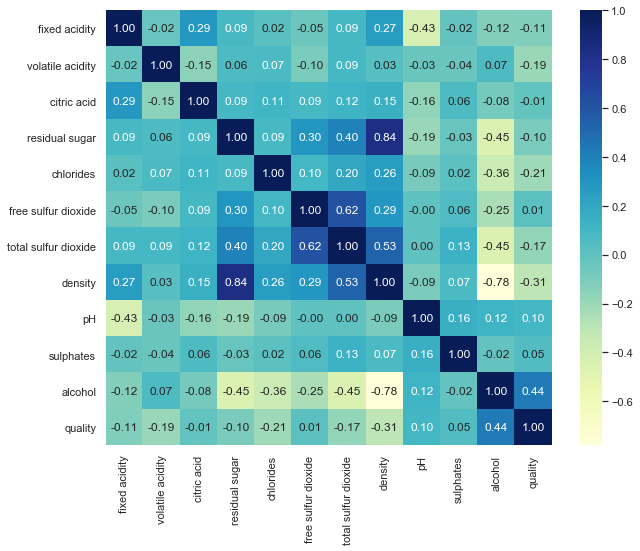

In [8]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap="YlGnBu",
            annot=True,
           fmt=".2f")
plt.show()

# Question 1.a - Regrestion
we'll try out three regresion models and compair them.
1. linear regrestion
2. SVM Regresor
3. neural network regresor

## Linear Regrestion

In [9]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
print(reg.score(X_test, Y_test))

from sklearn.metrics import mean_squared_error
a=reg.predict(X_train)
train_rmse= (mean_squared_error(a,Y_train)) ** 0.5
print(train_rmse)
b=reg.predict(X_test)
test_rmse= (mean_squared_error(b,Y_test)) ** 0.5
test_rmse

0.26612555925546766
0.7477827570657075


0.7651164452392171

## Polinomial Regresion

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

model = model.fit(X_train, Y_train)
# model.named_steps['linear'].coef_

In [11]:
from sklearn.metrics import mean_squared_error
a = model.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print(train_rmse)
b=  model.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print(test_rmse)

0.6997379383032644
0.8007861637342499


## SVM Regresor

In [12]:
regr_rbf = svm.SVR(kernel='rbf')
regr_lin = svm.SVR(kernel='linear')
regr_poly =svm.SVR(kernel='poly', degree = 2)
regr_rbf.fit(X_train, Y_train)
regr_lin.fit(X_train, Y_train)
regr_poly.fit(X_train, Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
print('regr_rbf score = ',regr_rbf.score(X_train,Y_train))
a = regr_rbf.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('regr_rbf train_rmse = ',train_rmse)
b=  regr_rbf.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('regr_rbf test_rmse = ', test_rmse)

print('regr_lin score = ',regr_lin.score(X_train,Y_train))
a = regr_lin.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('regr_lin train_rmse = ',train_rmse)
b=  regr_lin.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('regr_lin test_rmse = ', test_rmse)

print('regr_poly score = ',regr_poly.score(X_train,Y_train))
a = regr_poly.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('regr_poly train_rmse = ',train_rmse)
b=  regr_poly.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('regr_poly test_rmse = ', test_rmse)

regr_rbf score =  0.4983481075145304
regr_rbf train_rmse =  0.6259262171404174
regr_rbf test_rmse =  0.6969681348924257
regr_lin score =  0.27980412219595296
regr_lin train_rmse =  0.7499757667254886
regr_lin test_rmse =  0.767873190023259
regr_poly score =  0.21184190038090303
regr_poly train_rmse =  0.7845643794398706
regr_poly test_rmse =  0.8729852485567403


## Neural Network Regresor 

In [14]:
NN_model = Sequential()
NN_model.add(Dense(5, input_dim=11, activation= "relu"))
NN_model.add(Dense(4, activation= "selu"))
NN_model.add(Dense(2, activation= "selu"))
NN_model.add(Dense(1))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
NN_model.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
#history = NN_model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
history = NN_model.fit(X_train, Y_train, epochs=100, validation_split=0.2)


Train on 3212 samples, validate on 804 samples
Epoch 1/100
3212/3212 [==============================] - 0s 118us/step - loss: 29.7213 - mean_squared_error: 29.7213 - val_loss: 22.6981 - val_mean_squared_error: 22.6981
Epoch 2/100
3212/3212 [==============================] - 0s 54us/step - loss: 17.8928 - mean_squared_error: 17.8928 - val_loss: 13.8188 - val_mean_squared_error: 13.8188
Epoch 3/100
3212/3212 [==============================] - 0s 45us/step - loss: 11.0117 - mean_squared_error: 11.0117 - val_loss: 8.7352 - val_mean_squared_error: 8.7352
Epoch 4/100
3212/3212 [==============================] - 0s 47us/step - loss: 7.1127 - mean_squared_error: 7.1127 - val_loss: 5.8279 - val_mean_squared_error: 5.8279
Epoch 5/100
3212/3212 [==============================] - 0s 41us/step - loss: 4.8184 - mean_squared_error: 4.8184 - val_loss: 4.0203 - val_mean_squared_error: 4.0203
Epoch 6/100
3212/3212 [==============================] - 0s 39us/step - loss: 3.3529 - mean_squared_error: 3.35

3212/3212 [==============================] - 0s 62us/step - loss: 0.5895 - mean_squared_error: 0.5895 - val_loss: 0.6201 - val_mean_squared_error: 0.6201
Epoch 49/100
3212/3212 [==============================] - 0s 60us/step - loss: 0.5873 - mean_squared_error: 0.5873 - val_loss: 0.6173 - val_mean_squared_error: 0.6173
Epoch 50/100
3212/3212 [==============================] - 0s 62us/step - loss: 0.5842 - mean_squared_error: 0.5842 - val_loss: 0.6132 - val_mean_squared_error: 0.6132
Epoch 51/100
3212/3212 [==============================] - 0s 60us/step - loss: 0.5807 - mean_squared_error: 0.5807 - val_loss: 0.6096 - val_mean_squared_error: 0.6096
Epoch 52/100
3212/3212 [==============================] - 0s 57us/step - loss: 0.5785 - mean_squared_error: 0.5785 - val_loss: 0.6080 - val_mean_squared_error: 0.6080
Epoch 53/100
3212/3212 [==============================] - 0s 50us/step - loss: 0.5762 - mean_squared_error: 0.5762 - val_loss: 0.6038 - val_mean_squared_error: 0.6038
Epoch 54/10

3212/3212 [==============================] - 0s 61us/step - loss: 0.4967 - mean_squared_error: 0.4967 - val_loss: 0.5275 - val_mean_squared_error: 0.5275
Epoch 98/100
3212/3212 [==============================] - 0s 63us/step - loss: 0.4964 - mean_squared_error: 0.4964 - val_loss: 0.5352 - val_mean_squared_error: 0.5352
Epoch 99/100
3212/3212 [==============================] - 0s 60us/step - loss: 0.4968 - mean_squared_error: 0.4968 - val_loss: 0.5294 - val_mean_squared_error: 0.5294
Epoch 100/100
3212/3212 [==============================] - 0s 54us/step - loss: 0.4951 - mean_squared_error: 0.4951 - val_loss: 0.5305 - val_mean_squared_error: 0.5305


In [16]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


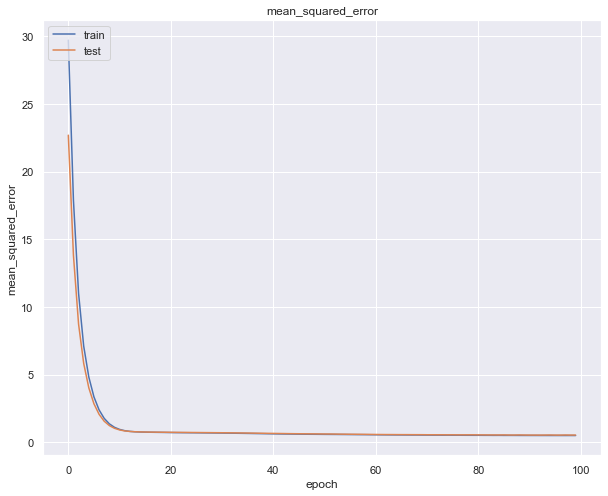

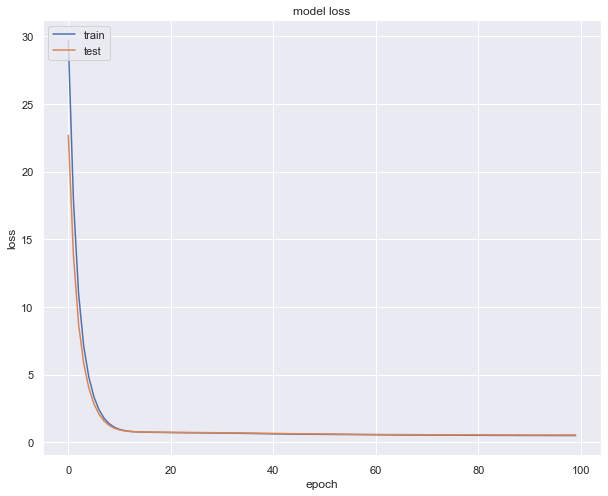

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
a = NN_model.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('NN train_rmse = ',train_rmse)
b=  NN_model.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('NN test_rmse = ', test_rmse)

NN train_rmse =  0.7071056621101943
NN test_rmse =  0.7182373713763812


In [19]:
a = NN_model.predict(X_train)
train_rmse = (mean_squared_error(a, Y_train)) ** 0.5
print('NN train_rmse = ',train_rmse)
b=  NN_model.predict(X_test)
test_rmse = (mean_squared_error(b, Y_test)) ** 0.5
print('NN test_rmse = ', test_rmse)

NN train_rmse =  0.7071056621101943
NN test_rmse =  0.7182373713763812


# Question 1.b - Clustering
we'll try out three clustering methoods and compair them.
1. DBSCAN
2. K-Means
3. GMM

# DBScan:

In [45]:
dbscan = DBSCAN(eps=math.sqrt(2), min_samples=2).fit(normalized_X)
hist_dictionary = {}
for i in dbscan.labels_:
    if str(i) in hist_dictionary:
        hist_dictionary[str(i)] = hist_dictionary[str(i)] + 1
    else:
        hist_dictionary[str(i)] = 1
clusters_names_numeric = [int(x) for x in hist_dictionary.keys()]
clusters_names_numeric.sort()
clusters_names = [str(name) for name in clusters_names_numeric]
points_amount_for_cluster = [hist_dictionary[x] for x in clusters_names]

clustering_hist_df = pd.DataFrame([points_amount_for_cluster])
clustering_hist_df.columns = clusters_names
clustering_hist_df

,-1,0,1,2,3,4,5,6,7,8,...,265,266,267,268,269,270,271,272,273,274
0,525,3647,4,2,3,2,6,4,5,6,...,2,2,4,2,2,2,2,2,2,2


# Kmeans:

In [23]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(normalized_X)
kmeans_labels = kmeans.labels_
hist_dictionary = {}
for i in kmeans_labels:
    if str(i) in hist_dictionary:
        hist_dictionary[str(i)] = hist_dictionary[str(i)] + 1
    else:
        hist_dictionary[str(i)] = 1
clusters_names_numeric = [int(x) for x in hist_dictionary.keys()]
clusters_names_numeric.sort()
clusters_names = [str(name) for name in clusters_names_numeric]
points_amount_for_cluster = [hist_dictionary[x] for x in clusters_names]

clustering_hist_df = pd.DataFrame([points_amount_for_cluster])
clustering_hist_df.columns = clusters_names
clustering_hist_df

,0,1,2,3,4,5,6,7,8,9
0,573,736,734,280,696,98,416,556,425,384


# MeanShift:

In [22]:
clustering = MeanShift(bandwidth=3).fit(normalized_X)
hist_dictionary = {}
for i in clustering.labels_:
    if str(i) in hist_dictionary:
        hist_dictionary[str(i)] = hist_dictionary[str(i)] + 1
    else:
        hist_dictionary[str(i)] = 1
clusters_names_numeric = [int(x) for x in hist_dictionary.keys()]
clusters_names_numeric.sort()
clusters_names = [str(name) for name in clusters_names_numeric]
points_amount_for_cluster = [hist_dictionary[x] for x in clusters_names]

clustering_hist_df = pd.DataFrame([points_amount_for_cluster])
clustering_hist_df.columns = clusters_names
clustering_hist_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,4366,96,7,3,10,16,2,1,14,7,...,28,1,1,18,26,1,5,1,3,28
